### ResNe50 을 이용한 식재료 이미지 객체 탐지

In [1]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 887.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=ce17a5f3706f6207f0ac55634a68a07cb7eff80696fbc6932da1e48d956719a4
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found 

### 데이터 다운로드
Roboflow  : <a href='https://universe.roboflow.com/onmk0428-naver-com/food-dlp59/dataset/2'>food-dlp59</a>

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Zv6K9jnOf2w4tz7CTlg")
project = rf.workspace("onmk0428-naver-com").project("food-dlp59")
dataset = project.version(2).download("multiclass")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to food-2 in multiclass:: 100%|██████████| 12346/12346 [00:03<00:00, 3211.01it/s]


### 데이터 확인

In [3]:
import os

train_path = '/content/food-2/train'
valid_path = '/content/food-2/valid'

train_fnames = os.listdir(train_path)
valid_fnames = os.listdir(valid_path)

class_file = [fname for fname in train_fnames if '.csv' in fname ]
class_file # class 파일
print(len(train_fnames))
print(len(valid_fnames))

9841
2501


In [4]:
import pandas as pd

#### class.csv 파일 확인

In [5]:
train_class = pd.read_csv(train_path+'/_classes.csv')
valid_class = pd.read_csv(valid_path+'/_classes.csv')

train_class.tail()

,filename,Apple,Banana,Broccoli,Cabbage,Cantaloupe,Carrot,Cucumber,Egg,Grape,Lemon,Mango,Mushroom,Orange,Peach,Pear,Pineapple,Potato,Pumpkin,Tomato
9835,50f3c620a163d796_jpg.rf.fffcf1b940b1ec25729266...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9836,0935a4b02465512b_jpg.rf.ff5be46f6eabe8768693e1...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
9837,0432875b5ec6bfb0_jpg.rf.fff4c3d2d2eb5d00ef7208...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9838,96ddbb92f308e6f6_jpg.rf.ffaefb3f91415c7d5e1681...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9839,ede79ee6797675e6_jpg.rf.ffe4fa2ca731845fcd5b6b...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


식재료 이미지 종류

- Apple
- Banana
-	Cabbage
-Cantaloupe
- Carrot
- Cucumber
- Egg
- Grape
- Lemon
- Mango
- Mushroom
- Orange
- Peach
- Pear
- Pineapple
- Potato
- Pumpkin
- Tomato

In [6]:
# label 확인
print(train_class.columns)
print(valid_class.columns)

Index(['filename', ' Apple', ' Banana', ' Broccoli', ' Cabbage', ' Cantaloupe',
       ' Carrot', ' Cucumber', ' Egg', ' Grape', ' Lemon', ' Mango',
       ' Mushroom', ' Orange', ' Peach', ' Pear', ' Pineapple', ' Potato',
       ' Pumpkin', ' Tomato'],
      dtype='object')
Index(['filename', ' Apple', ' Banana', ' Broccoli', ' Cabbage', ' Cantaloupe',
       ' Carrot', ' Cucumber', ' Egg', ' Grape', ' Lemon', ' Mango',
       ' Mushroom', ' Orange', ' Peach', ' Pear', ' Pineapple', ' Potato',
       ' Pumpkin', ' Tomato'],
      dtype='object')


### 데이터 전처리
ResNet 모델에 사용할 수 있도록 데이터 전처리

- class.csv 파일에 담긴 레이블 정보를 이용해 jpg 파일 별 식재료 폴더를 생성   

In [7]:
train_label_mapping = {}
valid_label_mapping = {}
# filename 과 값이 1 label 매핑
for _, row in train_class.iterrows():
    filename = row['filename']
    labels = [label.strip()  for label, value in row.items() if label != 'filename' and value == 1]
    train_label_mapping[filename] = labels

for _, row in valid_class.iterrows():
    filename = row['filename']
    labels = [label.strip()  for label, value in row.items() if label != 'filename' and value == 1]
    valid_label_mapping[filename] = labels


In [8]:
# file 이름과 식재료 매핑

import shutil

# dataset 파일 생성
base_dir = './dataset'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)

labels = map(str.strip, valid_class.columns.values)
labels = [lable for lable in labels if lable != 'filename' ]

# 식재료 label 별 폴더 생성
for cls in labels:
  os.mkdir(os.path.join(train_dir, cls))
  os.mkdir(os.path.join(validation_dir, cls))

# lable 폴더별 이미지 파일 복사
for filename in train_fnames:
  src = os.path.join(train_path, filename) # 복사되는 파일 주소
  if '_classes.csv' not in src:  # Exclude the '_classes.csv' file
    dst = os.path.join(os.path.join(train_dir, train_label_mapping[filename][0]), filename) # 복사한 파일이 저장되는 주소
    shutil.copyfile(src, dst)


for filename in valid_fnames:
  src = os.path.join(valid_path, filename) # 복사되는 파일 주소
  if '_classes.csv' not in src:  # Exclude the '_classes.csv' file
    dst = os.path.join(os.path.join(validation_dir, valid_label_mapping[filename][0]), filename) # 복사한 파일이 저장되는 주소
    shutil.copyfile(src, dst)



#### 식재료 폴더별 데이터 확인

In [9]:
labels = os.listdir(train_dir) # 식재료 폴더 리스트
print("count of labels: {}".format(len(labels)))
print("------------------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir(os.path.join(train_dir,label)))))

count of labels: 19
------------------------
Cabbage, 224 files
Apple, 854 files
Pear, 191 files
Mushroom, 1392 files
Tomato, 921 files
Banana, 557 files
Egg, 750 files
Peach, 126 files
Grape, 594 files
Mango, 101 files
Cantaloupe, 79 files
Potato, 245 files
Orange, 532 files
Broccoli, 370 files
Cucumber, 338 files
Pumpkin, 1346 files
Lemon, 515 files
Carrot, 466 files
Pineapple, 239 files


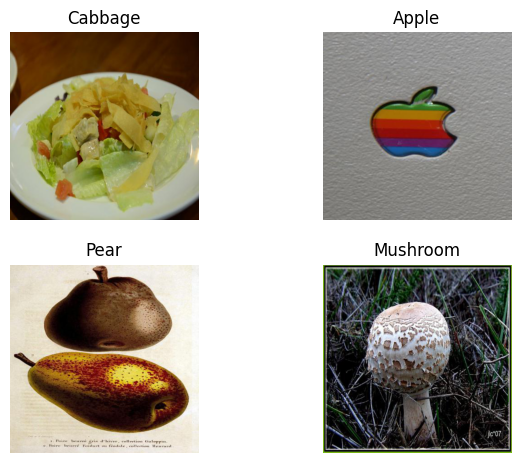

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
cnt = 0
for row in ax:
    for col in row:
        image_name = np.random.choice(os.listdir( os.path.join(train_dir,labels[cnt])))
        im = Image.open("./dataset/train/{}/{}".format(labels[cnt],image_name))
        col.imshow(im)
        col.set_title(labels[cnt])
        col.axis('off')
        cnt += 1

# fig.suptitle('Train dataset')
plt.show()

In [11]:
!pip list | grep -e fastai -e torch -e torchvision

fastai                           2.7.12
torch                            2.0.1+cu118
torchaudio                       2.0.2+cu118
torchdata                        0.6.1
torchsummary                     1.5.1
torchtext                        0.15.2
torchvision                      0.15.2+cu118


In [12]:
# ! pip install fastai --upgrade
# !pip install -U fastai

### Pytorch with ResNet50

In [13]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler


import os

In [40]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 128
epochs = 25

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./dataset"  # Replace this with the actual path to your dataset

full_dataset = ImageFolder(root=train_dir, transform=data_transforms["train"])

# Split full_dataset into train_dataset (80%) and validation_dataset (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, val_size])

# Create test_dataset using the "test" directory
test_dataset = ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transforms["test"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(validation_dataset),
    "test": len(test_dataset)
}

class_names = full_dataset.classes

for x in ["train", "val", "test"]:
    print(f"Number of samples in {x} dataset: {dataset_sizes[x]}")
print("Class names:", class_names)



Number of samples in train dataset: 7872
Number of samples in val dataset: 1968
Number of samples in test dataset: 2500
Class names: ['Apple', 'Banana', 'Broccoli', 'Cabbage', 'Cantaloupe', 'Carrot', 'Cucumber', 'Egg', 'Grape', 'Lemon', 'Mango', 'Mushroom', 'Orange', 'Peach', 'Pear', 'Pineapple', 'Potato', 'Pumpkin', 'Tomato']


In [41]:
loader = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}


In [42]:
from torchvision import models
#  ImageNet 데이터셋으로 학습된 가중치를 사용
resnet = models.resnet50(pretrained = True)
# ResNet50 모델의 마지막 fully connected(fc) 레이어의 입력 채널 수를 가져와 입력 차원 결정
num_ftrs = resnet.fc.in_features
# 모델은 19개의 클래스(식재료 종류)를 구분하는 다중 클래스 분류기로 변환됩니다.
resnet.fc = nn.Linear(num_ftrs, 19)
resnet = resnet.to(device)

# 다중 클래스 분류 문제를 해결하기 위해 교차 엔트로피 손실 함수를 사용
criterion = nn.CrossEntropyLoss()

# requires_grad=True인 파라미터들만 업데이트
optimizer_ft = optim.Adam(filter(lambda p : p.requires_grad, resnet.parameters()), lr=0.001)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 5, gamma = 0.1)

In [43]:

# 학습 및 검증 루프에서 다중 라벨 예측을 위한 함수 정의
def multi_label_predictions(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)  # 시그모이드 함수를 적용하여 확률 값으로 변환
    preds = (probs > threshold).float()  # 임계값과 비교하여 예측 결과 결정
    return preds

In [44]:
 # 첫 5개 층의 파라미터들을 비활성화
ct = 0
for child in resnet.children():
  ct += 1
  if ct < 6:
    for param in child.parameters():
      param.requires_grad = False

#### 모델 훈련

In [45]:
import copy, time


In [46]:
# def one_hot_encode(labels, num_labels, device):
#     one_hot_labels = torch.zeros(len(labels), num_labels, device=device)
#     for i, label in enumerate(labels):
#         one_hot_labels[i, label] = 1
#     return one_hot_labels

import torch.nn.functional as F

def one_hot_encode(labels, num_labels, device):
    one_hot_labels = F.one_hot(labels, num_classes=num_labels).float().to(device)
        return one_hot_labels

In [47]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs = 40):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(num_epochs):
        print(f"---------- epoch {epoch + 1} ----------")
        since = time.time()

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    x, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)       # 교차엔트로피 계산 deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장되있음
                                                                   # 한 배치 사이즈의 loss 총합을 계산!
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()
                l_r = [x["lr"] for x in optimizer_ft.param_groups]
                print("learning rate : ", l_r)

            epoch_loss = running_loss/dataset_sizes[phase]          # 전체 데이터 loss합을 각 데이터셋 전체 크기로 나눠주어 loss계산
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print("Completed in {:.0f}m {:0f}s".format(time_elapsed // 60, time_elapsed % 60))

    print("Best val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    return model

In [48]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler)
torch.save(model_resnet50, "resnet50_1.pt")

---------- epoch 1 ----------
learning rate :  [0.001]
train Loss: 2.127213 Acc: 0.3765
val Loss: 2.062875 Acc: 0.3994
Completed in 0m 43.923974s
---------- epoch 2 ----------
learning rate :  [0.001]
train Loss: 1.697591 Acc: 0.4882
val Loss: 2.092861 Acc: 0.4710
Completed in 0m 41.631321s
---------- epoch 3 ----------
learning rate :  [0.001]
train Loss: 1.617409 Acc: 0.5178
val Loss: 1.662779 Acc: 0.5137
Completed in 0m 39.959104s
---------- epoch 4 ----------
learning rate :  [0.001]
train Loss: 1.425096 Acc: 0.5696
val Loss: 1.622451 Acc: 0.4980
Completed in 0m 40.539392s
---------- epoch 5 ----------
learning rate :  [0.0001]
train Loss: 1.290925 Acc: 0.6016
val Loss: 1.511375 Acc: 0.5518
Completed in 0m 40.112514s
---------- epoch 6 ----------
learning rate :  [0.0001]
train Loss: 1.104833 Acc: 0.6561
val Loss: 1.376355 Acc: 0.5894
Completed in 0m 41.929680s
---------- epoch 7 ----------
learning rate :  [0.0001]
train Loss: 0.979831 Acc: 0.6905
val Loss: 1.344094 Acc: 0.5910
Co

In [49]:
# 모든 층의 학습 비활성화 상태 확인
for name, param in resnet.named_parameters():
    print(name, param.requires_grad)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias

#### 동결 해제하여 학습

In [52]:
#  requires_grad를 True로 설정하여 동결 해제
for param in resnet.parameters():
    param.requires_grad = True

# 모든 층의 학습 활성화 상태 확인
for name, param in resnet.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [54]:
optimizer_ft = optim.Adam(filter(lambda p : p.requires_grad, resnet.parameters()), lr=1.0000000000000004e-08)

model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, 10)
torch.save(model_resnet50, "resnet50_2.pt")

---------- epoch 1 ----------
learning rate :  [1.0000000000000004e-08]
train Loss: 0.732429 Acc: 0.7669
val Loss: 1.364870 Acc: 0.6174
Completed in 0m 40.550588s
---------- epoch 2 ----------
learning rate :  [1.0000000000000004e-08]
train Loss: 0.735978 Acc: 0.7645
val Loss: 1.347342 Acc: 0.6220
Completed in 0m 43.073157s
---------- epoch 3 ----------
learning rate :  [1.0000000000000004e-08]
train Loss: 0.730028 Acc: 0.7735
val Loss: 1.368081 Acc: 0.6133
Completed in 0m 41.946137s
---------- epoch 4 ----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

learning rate :  [1.0000000000000004e-08]
train Loss: 0.738941 Acc: 0.7660
val Loss: 1.381004 Acc: 0.6098
Completed in 0m 40.956916s
---------- epoch 5 ----------
learning rate :  [1.0000000000000004e-08]
train Loss: 0.741032 Acc: 0.7658
val Loss: 1.329852 Acc: 0.6159
Completed in 0m 39.659865s
---------- epoch 6 ----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

learning rate :  [1.0000000000000004e-08]
train Loss: 0.735320 Acc: 0.7707
val Loss: 1.358740 Acc: 0.6148
Completed in 0m 42.280996s
---------- epoch 7 ----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

learning rate :  [1.0000000000000004e-08]
train Loss: 0.745109 Acc: 0.7637
val Loss: 1.374485 Acc: 0.6057
Completed in 0m 41.474485s
---------- epoch 8 ----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
AssertionError
: can only test a child process
  File "/usr/lib/

learning rate :  [1.0000000000000004e-08]
train Loss: 0.746400 Acc: 0.7688
val Loss: 1.334452 Acc: 0.6286
Completed in 0m 41.260655s
---------- epoch 9 ----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

learning rate :  [1.0000000000000004e-08]
train Loss: 0.733810 Acc: 0.7674


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 1.350657 Acc: 0.6082
Completed in 0m 43.870470s
---------- epoch 10 ----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/

learning rate :  [1.0000000000000004e-08]
train Loss: 0.744596 Acc: 0.7621


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c289b9db1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 1.381698 Acc: 0.6143
Completed in 0m 42.342006s
Best val Acc: 0.6286


### 모델 평가

In [55]:
def show_data(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pa

In [56]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.data.cpu().numpy())

    dataset_size = len(dataloader.dataset)
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    print("Test Loss: {:.4f} Test Accuracy: {:.4f}".format(epoch_loss, epoch_acc))

    return all_preds, all_labels



In [57]:
model = torch.load('./resnet50_2.pt')

preds, labels = evaluate_model(model, test_loader, criterion)


Test Loss: 1.3241 Test Accuracy: 0.6196


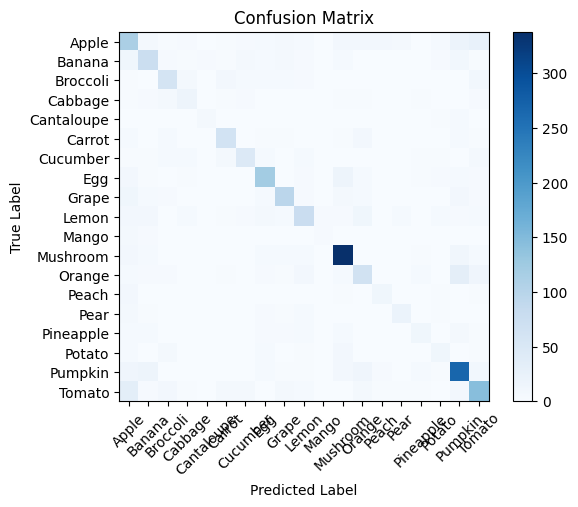

In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming 'all_preds' and 'all_labels' are lists containing predicted and ground truth labels, respectively
plot_confusion_matrix(labels, preds, class_names)


In [59]:
def imshow_with_labels(inputs, preds, labels, class_names, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        image = inputs[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(image)
        plt.title(f"True Label: {class_names[labels[i]]}\nPredicted Label: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


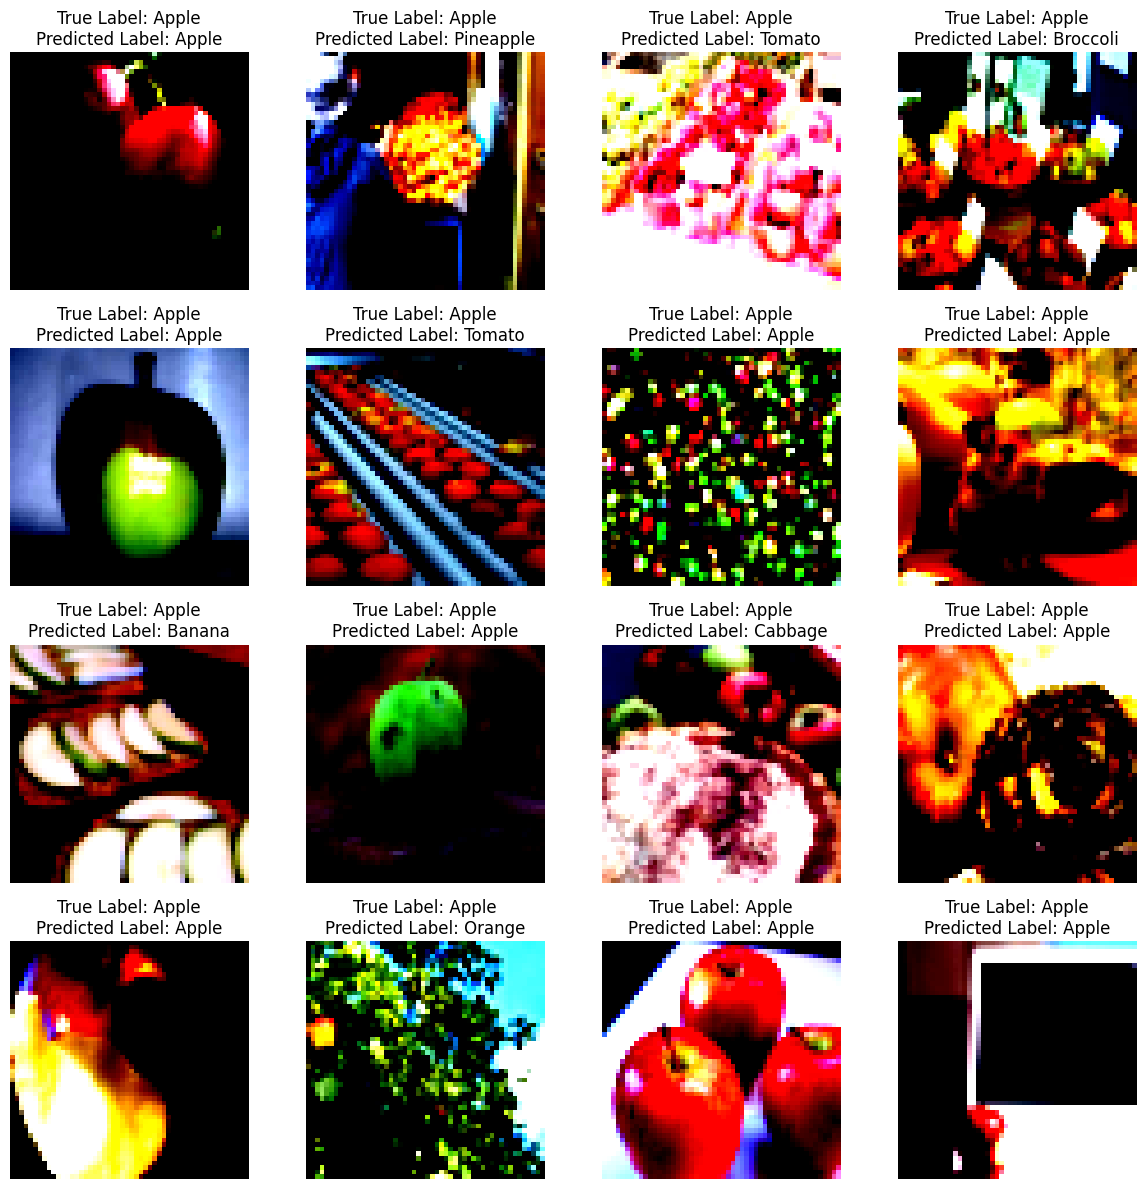

In [60]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

imshow_with_labels(inputs, preds, labels, class_names)
